# Visualizing the effect of different architectures

In this notebook, we will use different architectures to visualize the effect this has on the resulting image.

In [33]:
# reload imports so if you change stuff in models/cppn.py it'll update the notebook periodically to see it.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/01_CPPN')
from models.cppn import CPPN, Sampler, multiscale_targets_apply

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm

from IPython.display import display, clear_output
import time

Let's set up a list of architectures we want to explore that might be interesting.

In [35]:
net_sizes = [
    3 * [32],
    8 * [32] + [9, 3],
    3 * [512] + [9, 3],
    3 * ([512, 256, 4]),
    3 * [512, 256] + [2],
    [8, 256, 256, 64, 32, 6, 6, 6]
]
dim_z = 16
dim_c = 3

# Fourier Features settings
proj_dims = [128]
proj_scales = [2. for i in proj_dims]
projection_config = (proj_dims, proj_scales)


# Generate an Example Image

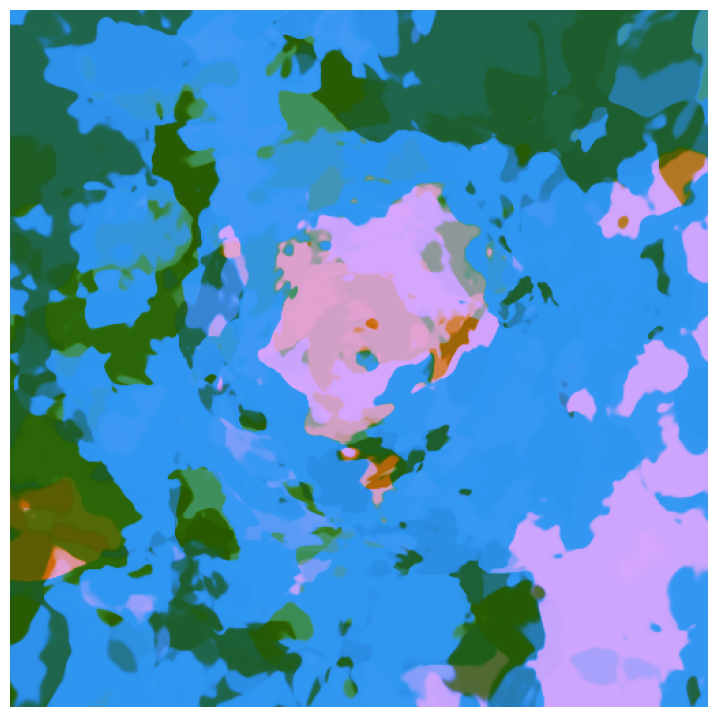

In [36]:
idx_net = 2
cppn = CPPN(net_sizes[idx_net], dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)
cppn.reinit(empty_cache=True)

gscale = 1
scale = 1.
xres = 512
yres = int(512*1 )
zscale = 1.
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

# coords[2] = coords[2] * 0.

x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow((x * 255).astype(np.uint8))

Now let's make some images with each of the different architectures for a number of different instances.

# Generate images

Make a loop that generates images with a number of different architectures with a couple of instances of each architecture.

In [37]:
num_models = 5

figure_imgs = []
for i_arch in tqdm(range(len(net_sizes))):
    cppn = CPPN(net_sizes[i_arch], dim_z, dim_c, projection_config=projection_config).cuda()
    arch_images = []
    for i_m in range(num_models):
        # reinit the model
        cppn.reinit(empty_cache=True)
        with torch.no_grad():
            x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
        
        arch_images.append(x)
    figure_imgs.append(arch_images)

100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


# Settings up the figures

In [38]:
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 10
})


cm = 1/2.54  # centimeters in inches

# size of full-width figures:
#fig = plt.figure(figsize=(18*cm, xx*cm))

# size of half-width figures:
#fig = plt.figure(figsize=(9*cm, 12.4*cm))

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_1180\2586124023.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


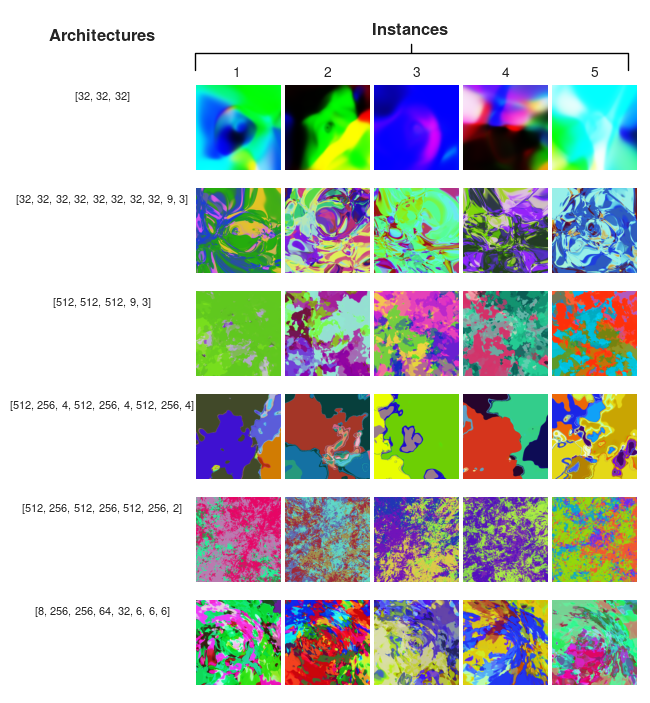

In [40]:
empty_columns = 2
N = num_models + empty_columns
M = len(net_sizes)

fig, axes = plt.subplots(nrows=M, ncols=N, figsize=(8, 8))

# If only one row or column, axes is not a 2D array
if N == 1 or M == 1:
    axes = np.array(axes).reshape(M, N)

# Loop through the grid and display images
for i in range(M): #rows
    for j in range(0, N): #columns
        ax = axes[i, j]
        
        if j == 0:
            fig.text(1., 0.8, ''.join(str(net_sizes[i])), 
                     transform=ax.transAxes, ha='center', va='center',
                     fontsize=8)
        
        
        # plot the cppn images
        if j > (empty_columns - 1):
            ax.imshow(figure_imgs[i][j - empty_columns])
            if i == 0:
                ax.set_title(f'{j-1}', fontsize=10)
                
        ax.axis('off')
# Manually position a text annotation
fig.text(1., 1.4, r'\textbf{Architectures}', transform=axes[0, 0].transAxes, ha='center', va='center', fontsize=12)
model_mid_x = 2/N + (N-2)/N/2 - 0.01
plt.annotate(r'\textbf{Instances}', xy=(model_mid_x, 0.92), xytext=(model_mid_x, 0.945), xycoords='subfigure fraction',
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=13.0, lengthB=1.', lw=1.0, color='k'))

plt.tight_layout()

plt.subplots_adjust(wspace=0.05, hspace=0.02) 
# plt.savefig('../figures/cppn_architectures_new.pdf', bbox_inches='tight')

plt.show()